## CNN 모델 구현

### 데이터셋 : cifar10

In [0]:
from keras.datasets import cifar10
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
num_classes = 10

In [0]:
label_names = ['airplane','automobile','bird','cat','deer','dog',
              'frog','horse','ship','truck']

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape: ',x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# 오류를 대비한 스페어
X_train = x_train.copy()
Y_train = y_train.copy()

In [0]:
print("label = {}".format(y_train[0:15,0]))

label = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]


In [0]:
print("label = {}".format(label_names[y_train[0,0]]))

label = frog


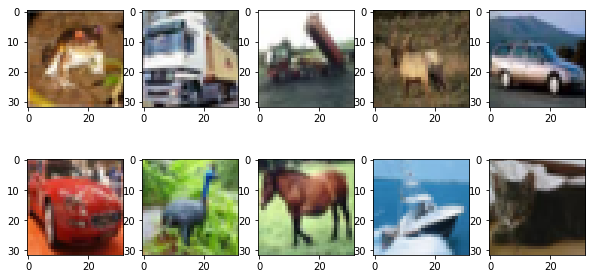

In [0]:
fix, ax = plt.subplots(2,5, figsize = (10,5))

for i in range(5) :
  ax[0][i].imshow(np.reshape(x_train[i], (32, 32, 3)))
  ax[1][i].imshow(np.reshape(x_train[i+5], (32,32,3)))

plt.show()

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y = tf.placeholder(tf.float32, [None, 10])

In [0]:
# 확인
print(y_train.shape)

(50000, 10)


### 신경망 구성

In [0]:
keep_prob = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal([5,5,3,32], stddev=0.01))
L1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
L1 = tf.nn.dropout(L1, keep_prob)

print(L1)

Tensor("dropout_19/mul_1:0", shape=(?, 16, 16, 32), dtype=float32)


In [0]:
## 2nd 신경망 CONV 3X2 64개 활성화함수 relu max_Pool를 2X2 stride2
## 3rd ...

## 처음 이미지 16 x 16 x 32
## 커널 3 x 3 x 32 커널개수 : 64 (padding이 있기 때문에)
## 16 x 16 x 64 (커널개수)

## 풀링에 의해
## 16 x 16 x 64 -> 2 x 2 -> stride =2
## 8 x 8 x 64

In [0]:
W2 = tf.Variable(tf.random_normal([5,5,32,64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides = [1,1,1,1], padding='SAME')
L2 = tf.nn.relu(L2)

L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides = [1,2,2,1],padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob)

print(L2)

Tensor("dropout_21/mul_1:0", shape=(?, 8, 8, 64), dtype=float32)


In [0]:
## 활성화맵 8 x 8 x 32
## 8 x 8 x 128 (커널개수)

## 풀링에 의해
## 4 x 4 x 128

In [0]:
W3 = tf.Variable(tf.random_normal([5, 5, 64, 128], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides = [1,1,1,1], padding='SAME')
L3 = tf.nn.relu(L3)

L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides = [1,2,2,1], padding="SAME")
L3 = tf.nn.dropout(L3, keep_prob)


print(L3)

Tensor("dropout_22/mul_1:0", shape=(?, 4, 4, 128), dtype=float32)


In [0]:
W4 = tf.Variable(tf.random_normal([4*4*128, 256]))
L4 = tf.reshape(L3, [-1, 4*4*128])
L4 = tf.matmul(L4, W4)
L4 = tf.nn.relu(L4)
#L4 = tf.nn.dropout(L4, keep_prob)
print(L4)

Tensor("Relu_43:0", shape=(?, 256), dtype=float32)


In [0]:
W5 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))

model = tf.matmul(L4, W5)
model

<tf.Tensor 'MatMul_22:0' shape=(?, 10) dtype=float32>

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model,
                                                                labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# 다음 배치를 읽어오기 위한 next_batch 유틸리티 함수를 정의합니다.
# 몇 개를 가져올까? : num
# data : 우리가 사용하는 데이터 (입력)
# lables : 우리가 사용하는 데이터 (출력)
def next_batch(start, num, data, labels):
  '''
  num 개수 만큼의 랜덤한 샘플들과 레이블들을 리턴합니다.
  '''
  # idx = np.arange(0 , len(data))
  # np.random.shuffle(idx)
  # idx = idx[:num]
  # data_shuffle = [data[i] for i in idx]
  # labels_shuffle = [labels[i] for i in idx]
  '''
  num 개수 만큼의 샘플과 레이블들을 리턴합니다.
  '''
  data_X = data[start:start+num]
  data_y = labels[start:start+num]
  return np.asarray(data_X), np.asarray(data_y)

In [0]:
#keep_prob = tf.placeholder(tf.float32)

batch_size = 100
total_batch = int(x_train.shape[0]/batch_size)
epoch = 0

for epoch in range(100) :
  total_cost = 0
  
  for i in range(total_batch) :
    batch_image, batch_label = next_batch(batch_size*i, batch_size, x_train, y_train)
    
    #batch_image = batch_image.reshape(-1, 32, 32, 3)
    _, cost_val = sess.run([optimizer, cost], feed_dict = {X: batch_image,
                                                          Y: batch_label,
                                                          keep_prob : 0.8})
    total_cost += cost_val
    
  print('epoch: {} \t total.cost = {:.4f}'.format(epoch+1, total_cost))

epoch: 1 	 total.cost = 1163.9328
epoch: 2 	 total.cost = 1104.8828
epoch: 3 	 total.cost = 946.4681
epoch: 4 	 total.cost = 890.2726
epoch: 5 	 total.cost = 854.5491
epoch: 6 	 total.cost = 834.0997
epoch: 7 	 total.cost = 812.8633
epoch: 8 	 total.cost = 806.3228
epoch: 9 	 total.cost = 794.5532
epoch: 10 	 total.cost = 779.5891
epoch: 11 	 total.cost = 777.7391
epoch: 12 	 total.cost = 762.2872
epoch: 13 	 total.cost = 763.5322
epoch: 14 	 total.cost = 749.9669
epoch: 15 	 total.cost = 749.7898
epoch: 16 	 total.cost = 738.8417
epoch: 17 	 total.cost = 743.0286
epoch: 18 	 total.cost = 733.9200
epoch: 19 	 total.cost = 731.7859
epoch: 20 	 total.cost = 724.9511
epoch: 21 	 total.cost = 723.1324
epoch: 22 	 total.cost = 719.3329
epoch: 23 	 total.cost = 707.4193
epoch: 24 	 total.cost = 714.4155
epoch: 25 	 total.cost = 709.6285
epoch: 26 	 total.cost = 706.3136
epoch: 27 	 total.cost = 712.8063
epoch: 28 	 total.cost = 704.9268
epoch: 29 	 total.cost = 698.7337
epoch: 30 	 total.cos

## 실제 검색 이미지를 이용한 예측

In [0]:
import cv2
from google.colab import files
uploaded = files.upload()

Saving 324489786cca4d6b852e009dfa755cd9.jpg to 324489786cca4d6b852e009dfa755cd9.jpg


In [0]:
image_w = 32
image_h = 32

In [0]:
img = cv2.imread('/content/324489786cca4d6b852e009dfa755cd9.jpg')
print(img.shape)

(450, 600, 3)


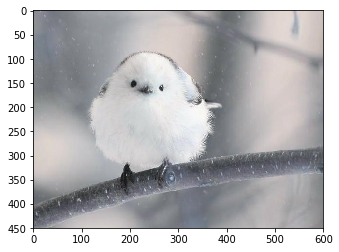

In [0]:
plt.imshow(img)

In [0]:
img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])

(32, 32, 3)

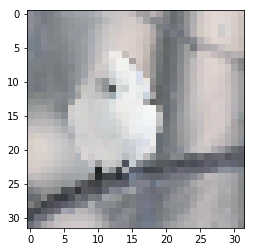

In [0]:
plt.imshow(img)
img.shape

In [0]:
# print(img.shape)
# img_re = img.reshape(1, 32*32*3)
# img_re = img_re.astype('float32') / 255.0
# print(img_re.shape)
# img_re

In [0]:
# Y_train[0:15]

In [0]:
result = tf.argmax(model,1)
idx = sess.run(result, feed_dict = {X: img.reshape(-1, 32, 32, 3),
                                       keep_prob : 1})
print('예측레이블 :', label_names[idx[0]])

예측레이블 : ship
